In [19]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [20]:
# read in all the words
words = open('names.txt', 'r').read().splitlines()
print(words[:8])
print(len(words))

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']
32033


In [21]:
# build the vocab of characters and mapping to and from the integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i, s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s, i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [ ]:
# building the dataset
block_size = 3

def build_dataset(words):
    X, Y = [], []

    for w in words:
        # print(w)
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]  # crop and append

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])
X, Y = build_dataset(words)

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])
torch.Size([228146, 3]) torch.Size([228146])


In [ ]:
n_embd = 10  # dimension of character embedding vector
n_hidden = 200  # no. of neurons in hidden layer

g = torch.Generator().manual_seed(42)
C = torch.randn((vocab_size, n_embd), generator=g)
W1 = torch.randn((block_size*n_embd, n_hidden), generator=g) * (5/3) / ((n_embd * block_size)**0.5)
# has no effect when using batchnorm after it
#b1 = torch.randn(n_hidden, generator=g) * 0.01
W2 = torch.randn((n_hidden, vocab_size), generator=g) * 0.01
b2 = torch.randn(vocab_size, generator=g) * 0

bngain = torch.ones((1, n_hidden))
bnbias = torch.zeros((1, n_hidden))
bnmean_running = torch.zeros((1, n_hidden))
bnstd_running = torch.ones((1, n_hidden))

parameters = [C, W1, W2, b2, bngain, bnbias]  # removed b1

for p in parameters:
    p.requires_grad = True

print(sum(p.nelement() for p in parameters))

12297


##### Explanation of `hpreact.mean(0, keepdim=True)` and `hpreact.std(0, keepdim=True)`

Dimension 0 (first dimension): Different examples in your batch

Dimension 1 (second dimension): Different neurons in your hidden layer

When you specify `dim=0` in `mean()` or `std()`:

- You're calculating statistics across the batch dimension
- For each neuron (each position in the hidden_dim), you get the mean/std across all examples in the batch
- This gives you the "average activation" and "activation variability" of each neuron

In [ ]:
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):

    # minibatch construction
    ix = torch.randint(0, Xtr.shape[0], (32,))  # generates 32 numbers lying between 0 and X.shape[0]
    Xb, Yb = Xtr[ix], Ytr[ix]  # X: (32, block_size), Y: (32)

    # forward pass
    emb = C[Xb]  # embed the characters into vectors  emb: (32, block_size, embedding_dim)
    embcat = emb.view(emb.shape[0], -1)  # concatenate the vectors  embcat: (32, block_size * embedding_dim)
    # Linear layer
    hpreact = embcat @ W1 #+ b1  # hidden layer pre-activation  hpreact: (32, hidden_dim)
    # BatchNorm layer
    # -------------------------------------------------------------
    bnmeani = hpreact.mean(0, keepdim=True)
    bnstdi = hpreact.std(0, keepdim=True)
    hpreact = bngain * (hpreact - bnmeani) / bnstdi + bnbias
    
    # updating bnmean and bnstd on the fly so we don't have to at the end all at once
    with torch.no_grad():
        bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani
        bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi
    # -------------------------------------------------------------
    # Non-linearity
    h = torch.tanh(hpreact)  # hidden layer
    logits = h @ W2 + b2  # output layer  logits: (32, vocab_size)
    loss = F.cross_entropy(logits, Yb)

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # update
    lr = 0.1 if i < 100000 else 0.01  # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    if i % 10000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())

      0/ 200000: 3.3058
  10000/ 200000: 1.8708
  20000/ 200000: 2.0023
  30000/ 200000: 2.0560
  40000/ 200000: 2.3204
  50000/ 200000: 2.0877
  60000/ 200000: 2.1771
  70000/ 200000: 2.3321
  80000/ 200000: 1.9499
  90000/ 200000: 2.0082
 100000/ 200000: 2.0592
 110000/ 200000: 1.9133
 120000/ 200000: 2.5358
 130000/ 200000: 1.9770
 140000/ 200000: 2.1468
 150000/ 200000: 2.0552
 160000/ 200000: 2.2539
 170000/ 200000: 2.1537
 180000/ 200000: 1.9062
 190000/ 200000: 2.0658


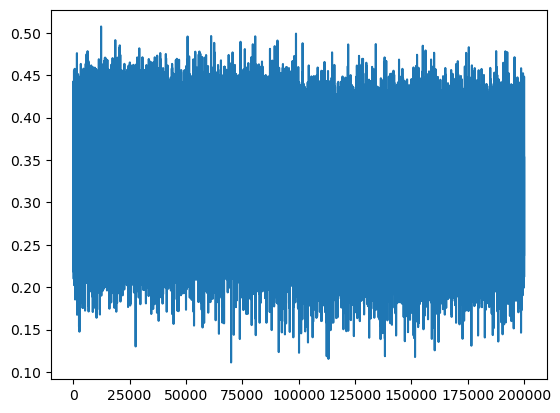

In [38]:
plt.plot(lossi)

In [ ]:
# calibrate the batch norm at the end of training
# we don't need this if we do on the fly updates

with torch.no_grad():
    # pass the training set through
    emb = C[Xtr]
    embcat = emb.view(emb.shape[0], -1)  # (no_of_examples, block_size * n_embd)
    hpreact = embcat @ W1 #+ b1
    # measure the mean/std over the entire training set
    bnmean = hpreact.mean(0, keepdim=True)
    bnstd = hpreact.std(0, keepdim=True)

In [ ]:
@torch.no_grad()  # disables gradient tracking
def split_loss(split):
    x, y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte),
    }[split]
    emb = C[x]  # (N, block_size, n_embd)
    embcat = emb.view(emb.shape[0], -1)  # (N, block_size, * n_embd)
    hpreact = embcat @ W1 #+ b1
    # hpreact = bngain * (hpreact - hpreact.mean(0, keepdim=True)) / hpreact.std(0, keepdim=True) + bnbias
    hpreact = bngain * (hpreact - bnmean_running) / bnstd_running + bnbias
    h = torch.tanh(hpreact)  # (N, n_hidden)
    logits = h @ W2 + b2  # (N, vocab_size)
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.069514274597168
val 2.108668327331543


In [ ]:
# sample from the model
g = torch.Generator().manual_seed(42)

for _ in range(20):
    
    out = []
    context = [0] * block_size  # initialize with all ...
    while True:
        # forward pass 
        emb = C[torch.tensor([context])]  # (1, block_size, n_embd)
        embcat = emb.view(1, -1)
        hpreact = embcat @ W1 #+ b1
        hpreact = bngain * (hpreact - bnmean) / bnstd + bnbias
        h = torch.tanh(hpreact)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)

        # sample from the distribution
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        # shift the context window and track the samples
        context = context[1:] + [ix]
        out.append(ix)
        # if we sample '.' token, break
        if ix == 0:
            break

    print(''.join(itos[i] for i in out))  # decode and print generated word

yansy.
haviah.
nolle.
khalei.
nya.
try.
weniten.
emberlynn.
ize.
abdeles.
lou.
topheevani.
pepo.
zandresleyanalei.
shina.
luna.
adari.
zeona.
reen.
keda.


### Extra

In [28]:
-torch.tensor(1/27.0).log()

tensor(3.2958)

tensor(0.0110) tensor(1.0032)
tensor(0.0002) tensor(0.9982)


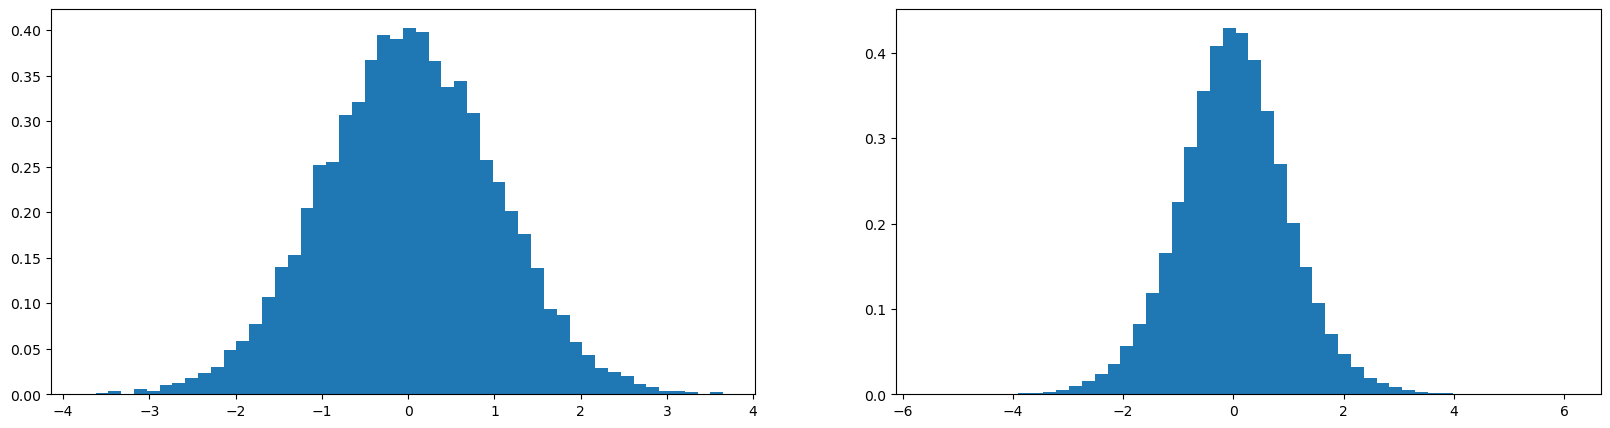

In [29]:
x = torch.randn(1000, 10)
w = torch.randn(10, 200) / 10**0.5
y = x @ w
print(x.mean(), x.std())
print(y.mean(), y.std())
plt.figure(figsize=(20, 5))
plt.subplot(121)
plt.hist(x.view(-1).tolist(), 50, density=True); 
plt.subplot(122)
plt.hist(y.view(-1).tolist(), 50, density=True);

### PyTorch-ifying the Code

In [ ]:
class Linear:

    def __init__(self, fan_in, fan_out, bias=True):
        self.weight = torch.randn((fan_in, fan_out), generator=g) / (fan_in)**0.5
        self.bias = torch.zeros(fan_out) if bias else None

    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out
    
    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])
    

class BatchNorm1d:

    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True
        # parameters (trained with backprop)
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)
        # buffers (trained with a running 'momentum update')
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)

    def __call__(self, x):
        if self.training:
            xmean = x.mean(0, keepdim=True)  # batch mean
            xvar = x.var(0, keepdim=True)  # batch variance
            # update buffer
            with torch.no_grad():
                self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
                self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
        else:
            xmean = self.running_mean
            xvar = self.running_var
        xhat = (x - xmean) / torch.sqrt(xvar + self.eps)  # normalization
        self.out = self.gamma * xhat + self.beta            
        return self.out
    
    def parameters(self):
        return [self.gamma, self.beta]
    

class Tanh:

    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out

    def parameters(self):
        return []
    

n_embd = 10  # dimensionality of the character embedding vectors
n_hidden = 100  # neurons in hidden layer
g = torch.Generator().manual_seed(42)


C = torch.randn((vocab_size, n_embd), generator=g)
layers = [
    Linear(n_embd * block_size, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, vocab_size),
]


with torch.no_grad():
    # last layer: make less confident
    layers[-1].weight *= 0.1
    # all other layers: apply gain
    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            layer.weight *= 5/3


parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters))  # number of parameters in total
for p in parameters:
    p.requires_grad = True

46497


In [ ]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):

    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix]

    # forward pass
    emb = C[Xb]  # embed the characters into vectors
    x = emb.view(emb.shape[0], -1)  # concatenate the vectors
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, Yb)

    # backward pass

    # not needed normally, this step is only because we want to visualize the gradients here
    # because intermediate values (self.out) in the computation graph have their gradients discarded after the backward pass to save memory
    for layer in layers:
        layer.out.retain_grad()
    
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if i < 100000 else 0.01  # step learning rate decay
    for p in parameters:
        p.data -= lr * p.grad

    # track stats
    if i % 10000 == 0:  # print every once in a while
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())

    break

      0/ 200000: 3.2900
